In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import norm, skew
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

In [2]:
df_train=pd.read_csv('Train.csv')
df_test=pd.read_csv('Test.csv')

In [3]:
df_train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [4]:
df_train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [5]:
df_train.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

<Axes: >

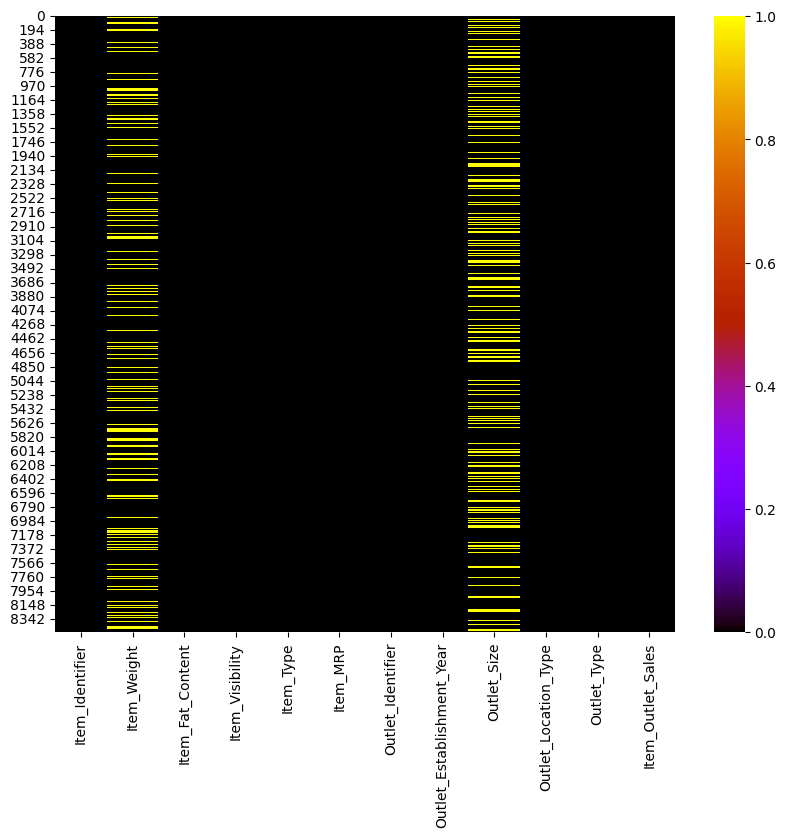

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.isna(),cmap='gnuplot')

In [7]:
df_train['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

C:\Users\local_urmi.pandya\Temp\ipykernel_25808\2547581262.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['Item_Weight'].dropna(),color='green')


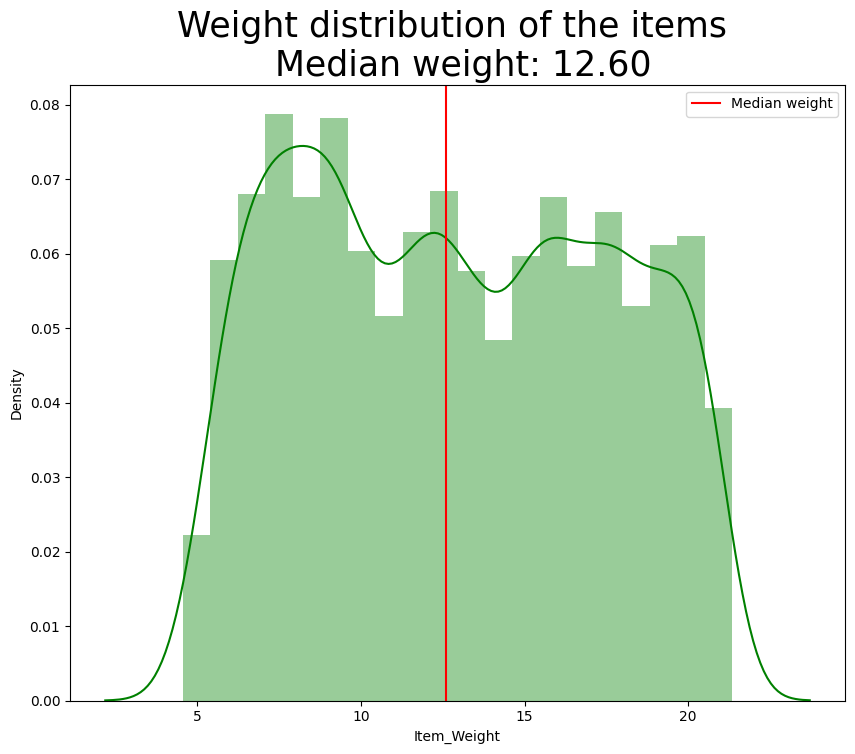

In [8]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Weight'].dropna(),color='green')
plt.title('Weight distribution of the items \n Median weight: {0:.2f}'.format(df_train['Item_Weight'].dropna().median()),size=25)
plt.axvline(df_train['Item_Weight'].dropna().median(),color='red',label='Median weight')
plt.legend()

Text(0.5, 1.0, 'Violinplot of weights')

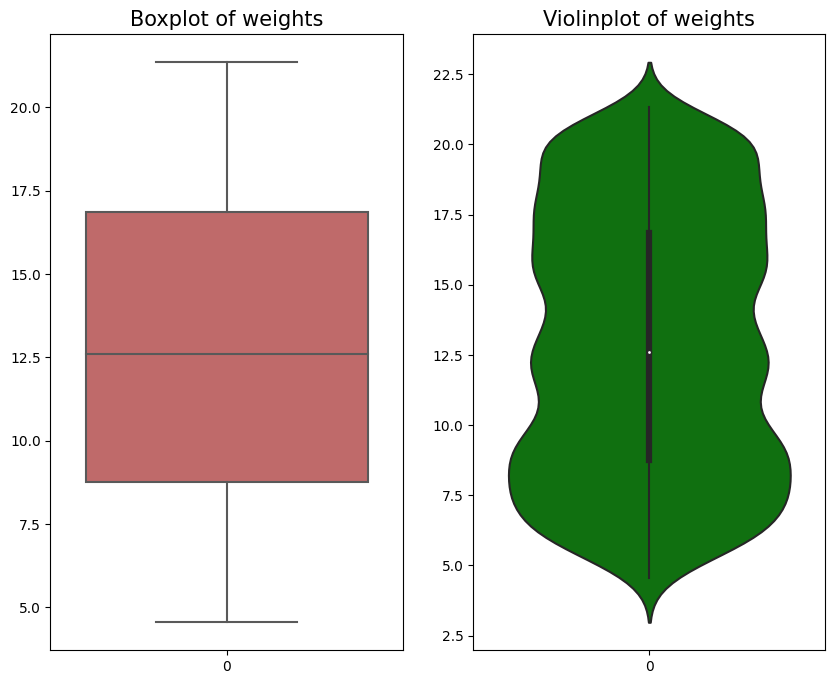

In [9]:
fig1=plt.figure(figsize=(10,8))
ax1=fig1.add_subplot(121)
sns.boxplot(df_train['Item_Weight'],ax=ax1,orient='v',color='indianred')
ax1.set_title('Boxplot of weights',size=15)

ax2=fig1.add_subplot(122)
sns.violinplot(df_train['Item_Weight'],ax=ax2,orient='v',color='green')
ax2.set_title('Violinplot of weights',size=15)

In [10]:
df_train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [11]:
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('low fat','Low Fat')
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('LF','Low Fat')
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].replace('reg','Regular')
df_train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [12]:
df_train['Count']=1
df_fat=df_train.groupby('Item_Fat_Content')['Count'].sum().reset_index()

fig2=px.pie(df_fat,values='Count',names='Item_Fat_Content',hole=0.4)

fig2.update_layout(title='Fat content',title_x=0.48,
                  annotations=[dict(text='Fat',font_size=15, showarrow=False,height=800,width=900)])
fig2.update_traces(textfont_size=15,textinfo='percent+label')
fig2.show()

In [13]:
df_train['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

C:\Users\local_urmi.pandya\Temp\ipykernel_25808\1334050810.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




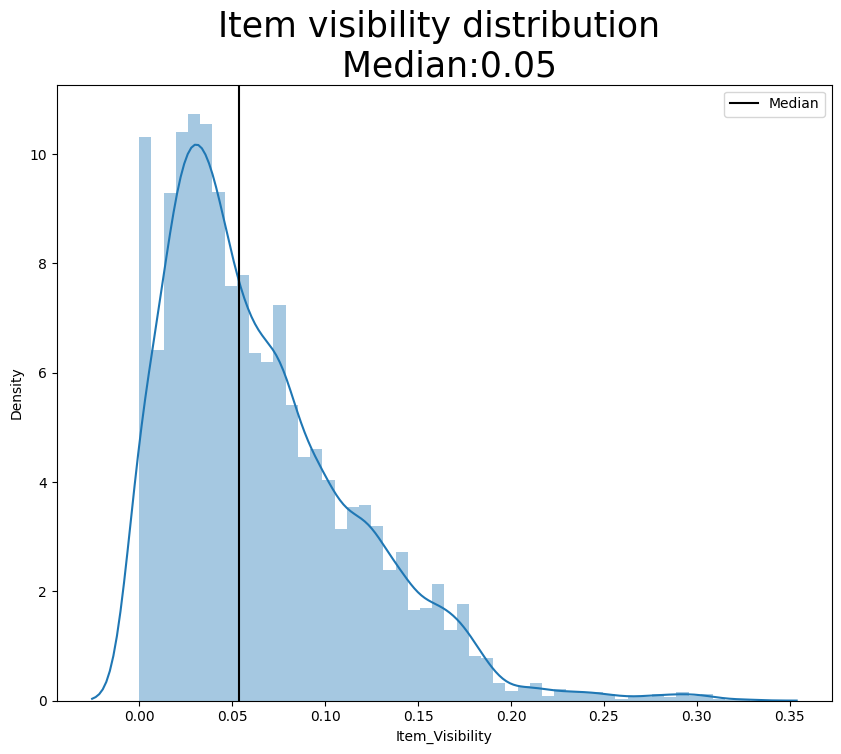

In [14]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Visibility'])
plt.title('Item visibility distribution \n Median:{0:.2f}'.format(df_train['Item_Visibility'].median()),size=25)
plt.axvline(df_train['Item_Visibility'].median(),color='black',label='Median')
plt.legend()

((array([-3.77092014, -3.54353752, -3.4185981 , ...,  3.4185981 ,
          3.54353752,  3.77092014]),
  array([0.        , 0.        , 0.        , ..., 0.32111501, 0.32578081,
         0.32839095])),
 (0.049348775274015044, 0.06613202877895107, 0.9560728731678176))

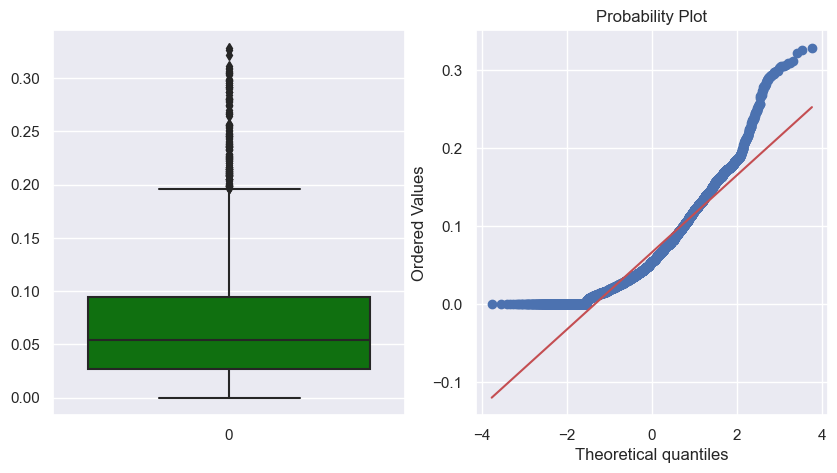

In [15]:
sns.set()
fig3=plt.figure(figsize=(10,5))
ax1=fig3.add_subplot(121)
sns.boxplot(df_train['Item_Visibility'],orient='v',ax=ax1,color='green')
ax2=fig3.add_subplot(122)
stats.probplot(df_train['Item_Visibility'],plot=ax2)

In [16]:
df_train[df_train['Item_Visibility']>0.2].shape[0]

134

((array([-3.7669643 , -3.53935697, -3.41428343, ...,  3.41428343,
          3.53935697,  3.7669643 ]),
  array([0.        , 0.        , 0.        , ..., 0.19899855, 0.19993588,
         0.19995527])),
 (0.04487626591626392, 0.06322235269591131, 0.9681235088881054))

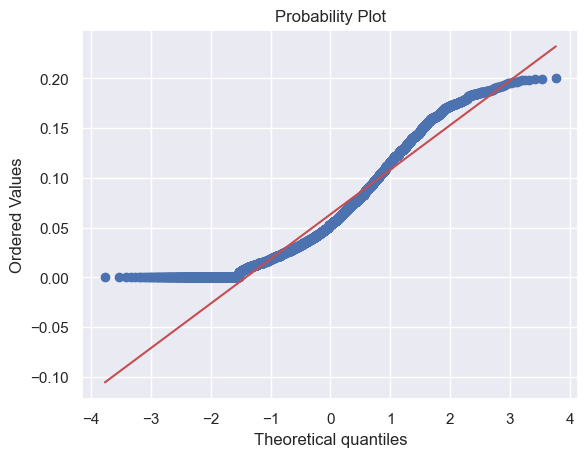

In [17]:
df_train=df_train[df_train['Item_Visibility']<0.2]
stats.probplot(df_train['Item_Visibility'],plot=plt)

C:\Users\local_urmi.pandya\Temp\ipykernel_25808\2445397571.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




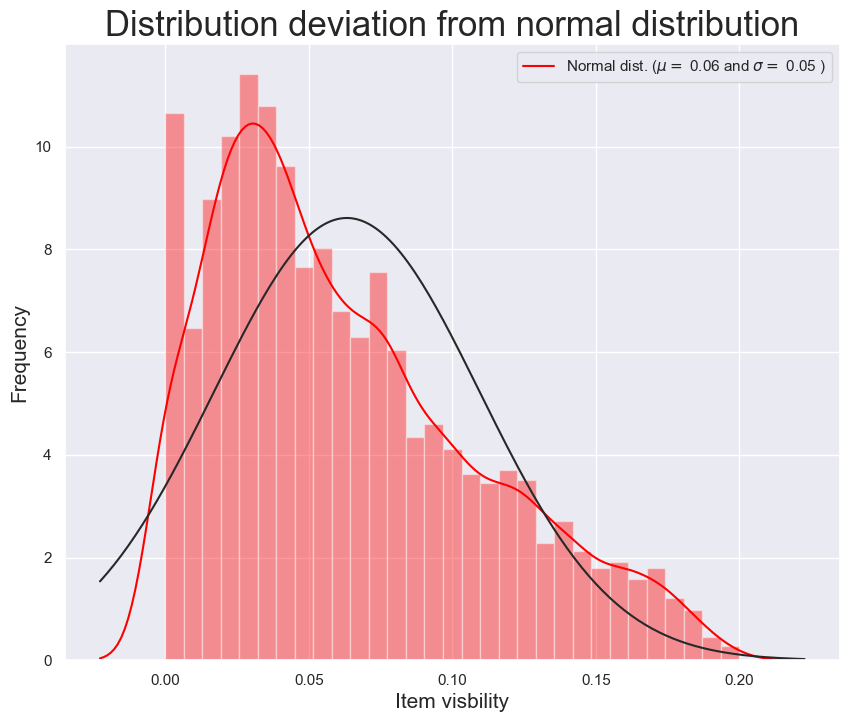

In [18]:
plt.figure(figsize=(10,8))
sns.distplot(df_train['Item_Visibility'],fit=norm,color='red')
plt.title('Distribution deviation from normal distribution',size=25)
plt.ylabel('Frequency',size=15)
plt.xlabel('Item visbility',size=15)
mu=df_train['Item_Visibility'].mean()
sigma=df_train['Item_Visibility'].std()
plt.legend(['Normal dist. ($\mu=$ {0:.2f} and $\sigma=$ {1:.2f} )'.format(mu, sigma)])

In [19]:
df_type=df_train.groupby('Item_Type')['Count'].sum().reset_index()
fig4=px.sunburst(df_train,path=['Item_Type','Item_Fat_Content'],names='Item_Type',color_continuous_scale='RdBu')
fig4.update_layout(title='Item types',title_x=0.2,title_y=0.8,
                  annotations=[dict(showarrow=True,height=1000,width=900)],margin=dict(l=20, r=20, t=20, b=20))
fig4.show()

fig5=px.pie(df_type,values='Count',names='Item_Type')
fig5.update_layout(title='Item distribution',title_x=0.1,title_y=0.8)
fig5.update_traces(textfont_size=15,textinfo='percent')
fig5.show()

C:\Users\local_urmi.pandya\Temp\ipykernel_25808\1172356773.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




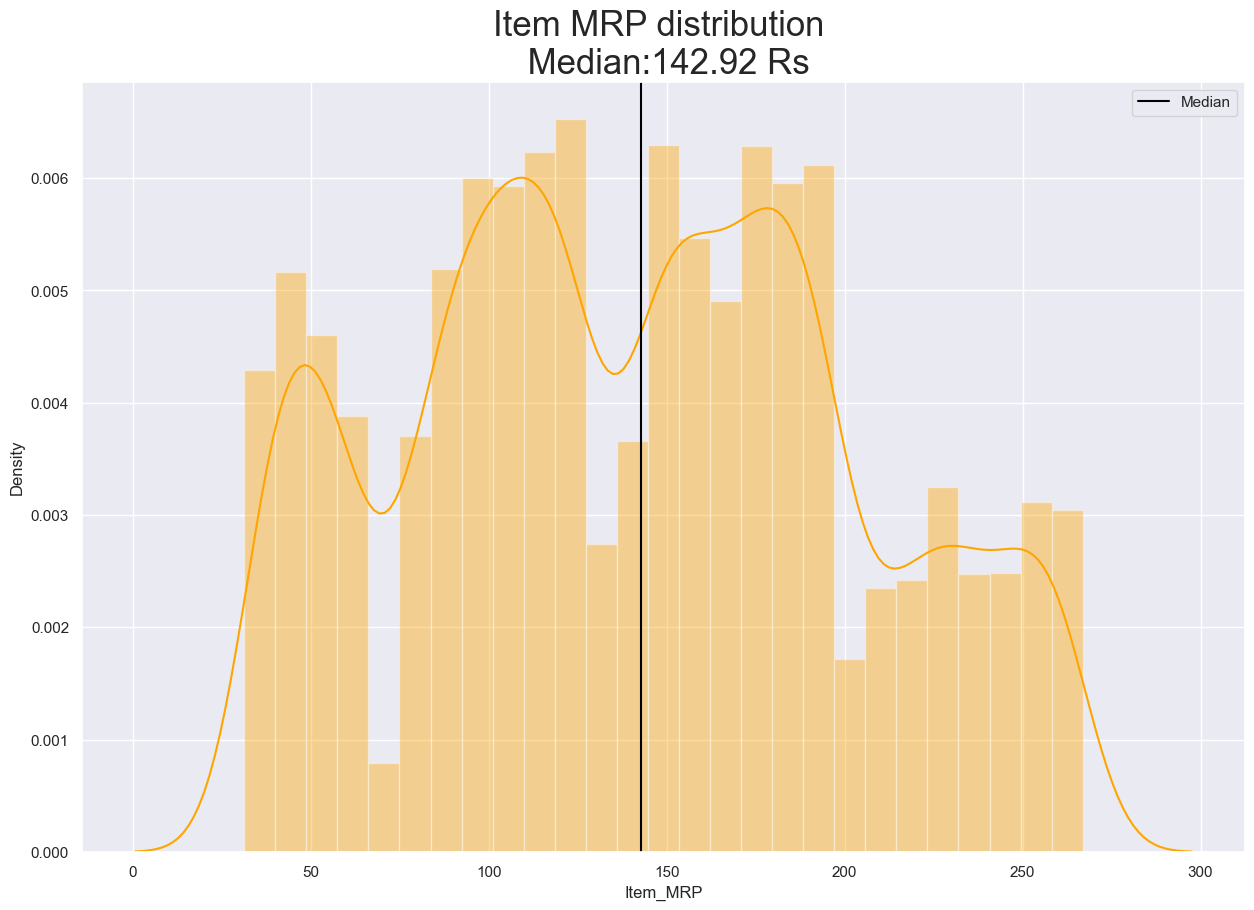

In [20]:
plt.figure(figsize=(15,10))
sns.distplot(df_train['Item_MRP'],color='orange')
plt.title('Item MRP distribution \n Median:{0:.2f} Rs'.format(df_train['Item_MRP'].median()),size=25)
plt.axvline(df_train['Item_MRP'].median(),color='black',label='Median')
plt.legend()

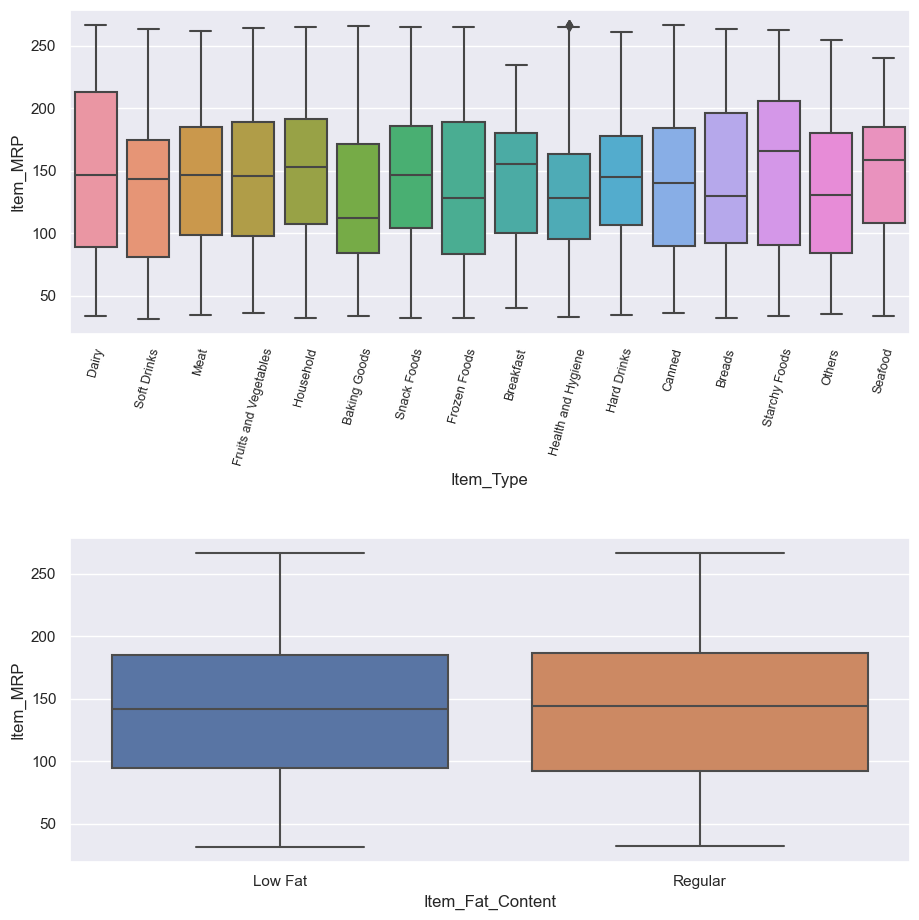

In [21]:
labels=df_train['Item_Type'].unique()
fig6=plt.figure(figsize=(10,10))
ax1=fig6.add_subplot(211)
sns.boxplot(x='Item_Type',y='Item_MRP',data=df_train,ax=ax1)
ax1.set_xticklabels(labels, rotation=75,size=9)

ax2=fig6.add_subplot(212)
sns.boxplot(x='Item_Fat_Content',y='Item_MRP',data=df_train,ax=ax2)

fig6.tight_layout(pad=3) #For spacing between subplots

In [22]:
df_outlets=df_train.groupby('Outlet_Identifier')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)

([<matplotlib.axis.YTick at 0x2059084a520>,
 [Text(0, 0, '0'),
  Text(0, 100, '100'),
  Text(0, 200, '200'),
  Text(0, 300, '300'),
  Text(0, 400, '400'),
  Text(0, 500, '500'),
  Text(0, 600, '600'),
  Text(0, 700, '700'),
  Text(0, 800, '800'),
  Text(0, 900, '900'),
  Text(0, 1000, '1000')])

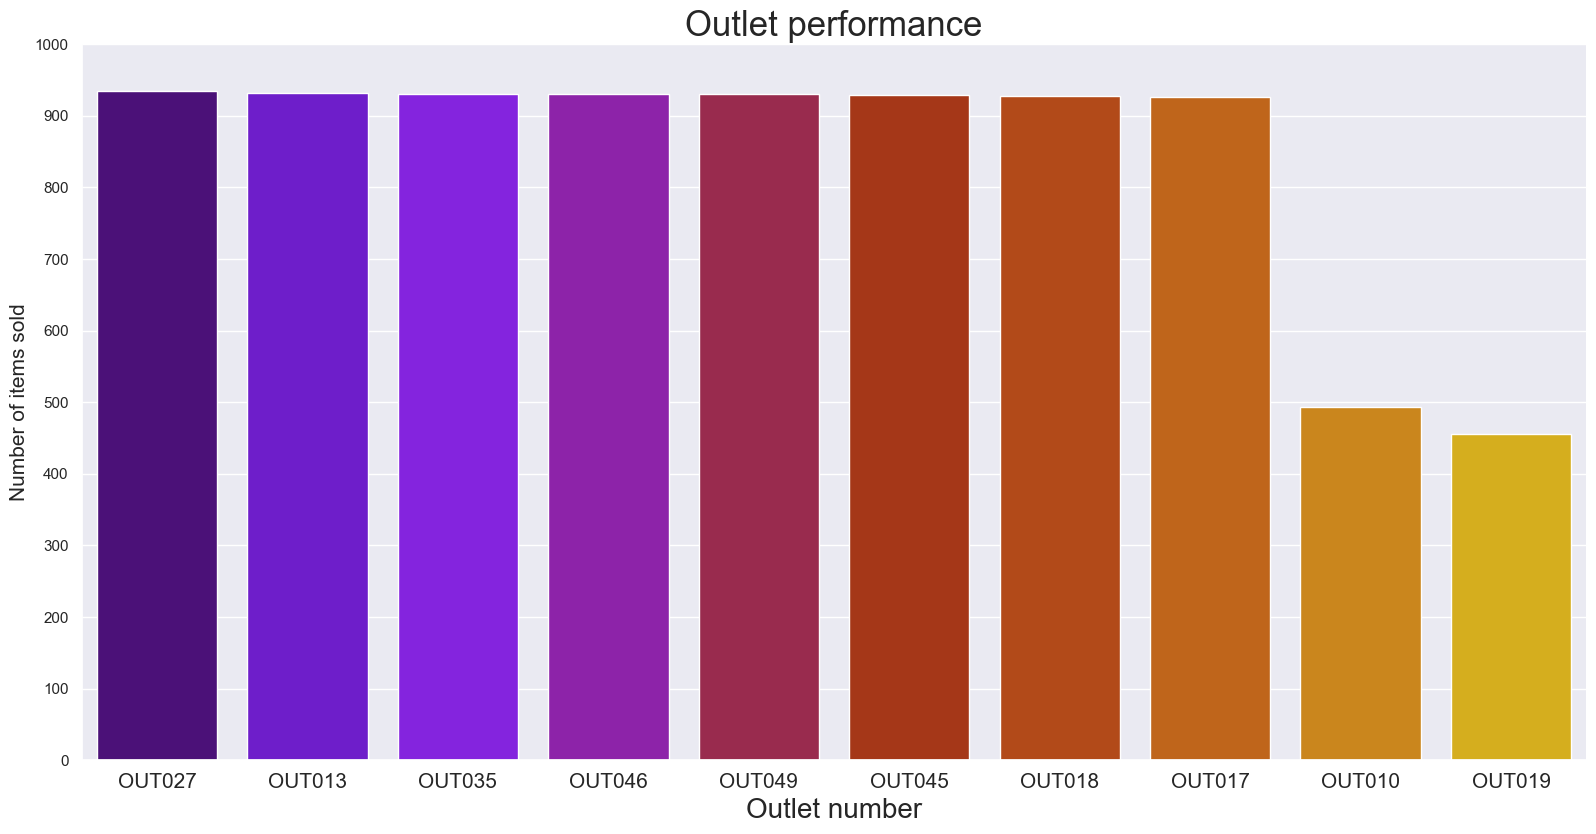

In [23]:
sns.catplot(x='Outlet_Identifier',y='Count',data=df_outlets,aspect=2,height=8,kind='bar',palette='gnuplot')
plt.xticks(size=15)
plt.ylabel('Number of items sold',size=15)
plt.xlabel('Outlet number',size=20)
plt.title('Outlet performance',size=25)
plt.yticks(np.arange(0,1100,100))

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Item_MRP'>

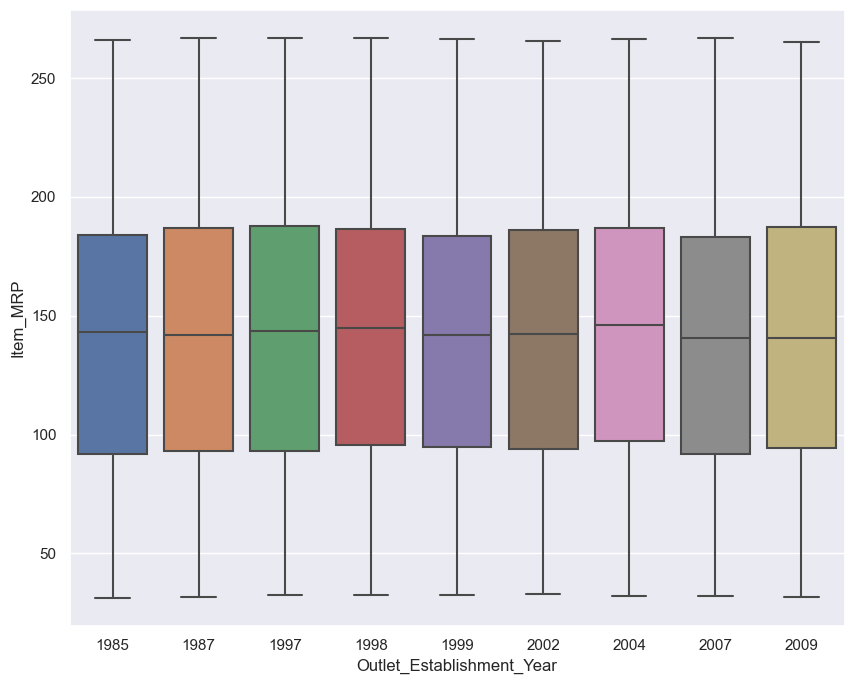

In [24]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Outlet_Establishment_Year',y='Item_MRP',data=df_train)

Text(0.5, 1.0, 'Outlet sales')

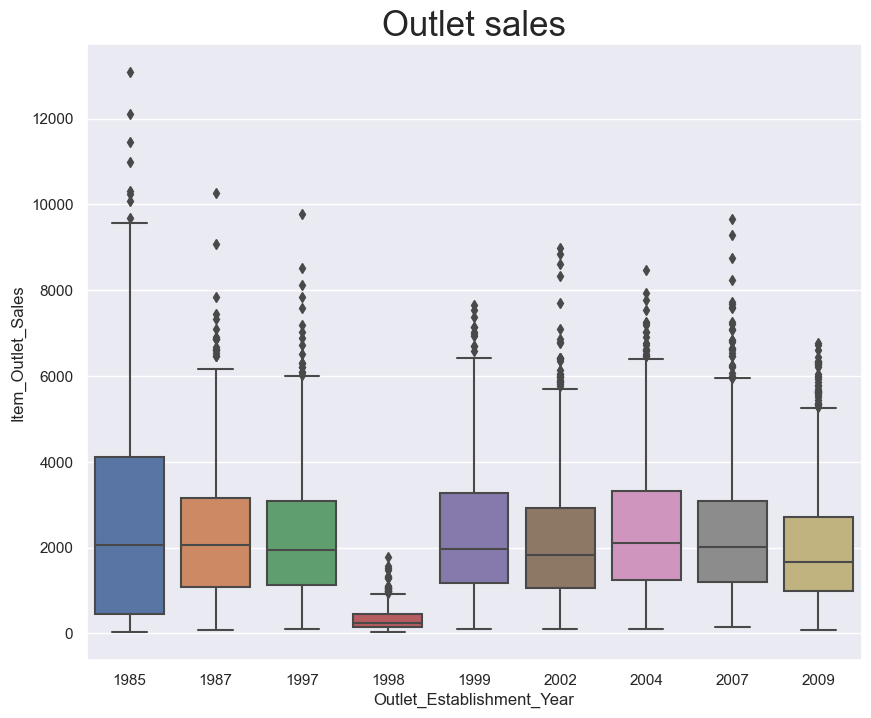

In [25]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Outlet_Establishment_Year',y='Item_Outlet_Sales',data=df_train)
plt.title('Outlet sales',size=25)

In [26]:
df_train['Outlet_Size'].isna().value_counts()

False    6041
True     2348
Name: Outlet_Size, dtype: int64

In [27]:
df_size=df_train.groupby('Outlet_Size')['Count'].sum().reset_index()
fig7=px.pie(df_size,values='Count',names='Outlet_Size',hole=0.4)
fig7.update_layout(title='Store sizes',title_x=0.5,annotations=[dict(text='Fat',font_size=15, showarrow=False,height=800,width=900)])
fig7.update_traces(textfont_size=15,textinfo='percent+label')
fig7.show()

In [28]:
df_size_sales=df_train.groupby('Outlet_Size')[['Item_MRP','Item_Outlet_Sales']].mean().reset_index()

In [29]:
df_size_sales

Outlet_Size    Item_MRP  Item_Outlet_Sales
0        High  141.425982        2298.995256
1      Medium  140.590514        2681.603542
2       Small  141.756737        1960.412740

Text(0.5, 1.0, 'Average sales of store')

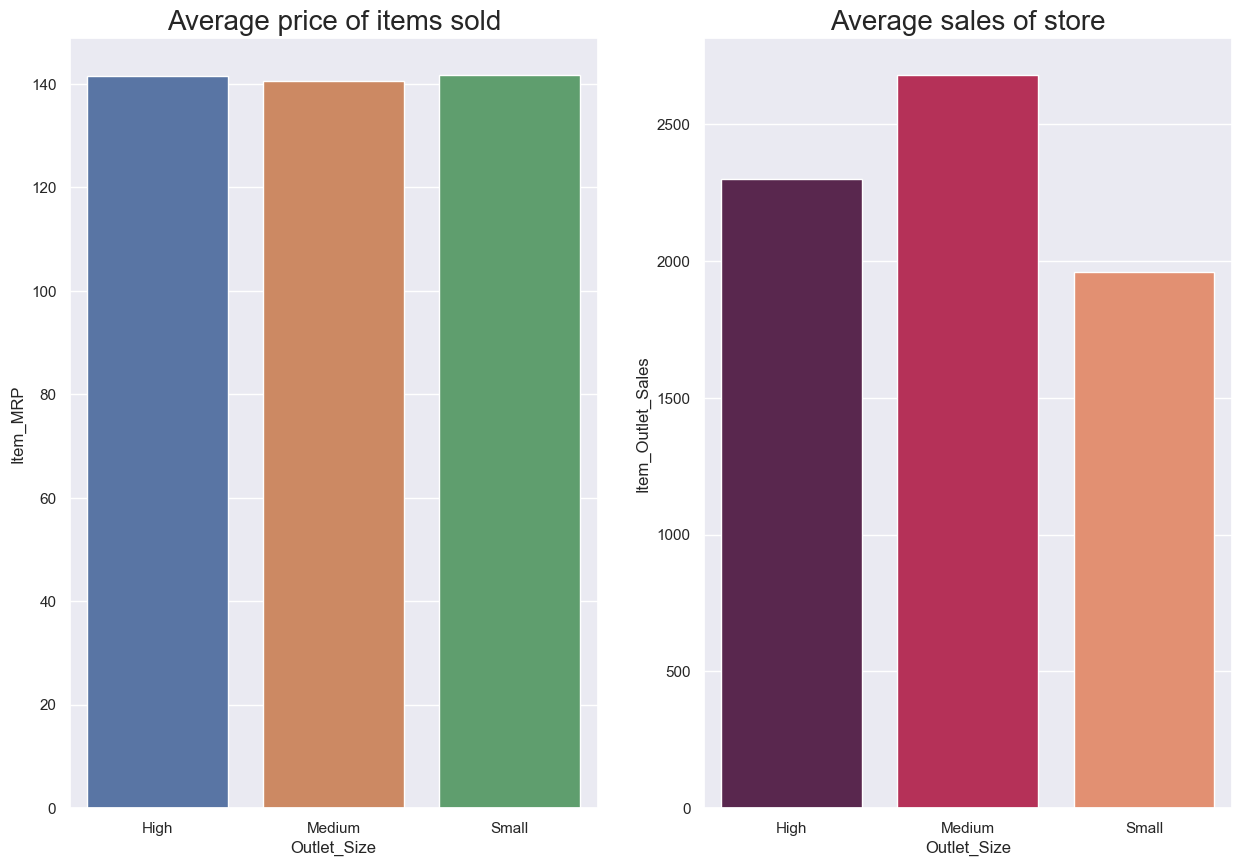

In [30]:
fig8=plt.figure(figsize=(15,10))
ax1=fig8.add_subplot(121)
sns.barplot(x='Outlet_Size',y='Item_MRP',data=df_size_sales,ax=ax1)

ax2=fig8.add_subplot(122)
sns.barplot(x='Outlet_Size',y='Item_Outlet_Sales',data=df_size_sales,ax=ax2,palette='rocket')

ax1.set_title('Average price of items sold',size=20)
ax2.set_title('Average sales of store',size=20)

In [31]:
df_train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  Count  
0  Supermarket Type1          3735.1380      1  
1  Supermarket Type2           443.4228      1  
2  Supermarket Type1          2097.2700      1  
3      Grocery Store           732.3800      1  
4  Supermarket Type1           994.7052      1

In [32]:
fig9=px.sunburst(df_train,path=['Outlet_Type','Outlet_Location_Type'],color_continuous_scale='RdBu')
fig9.update_layout(title='Store type with location type',title_x=0.5)
fig9.show()

<Axes: xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>

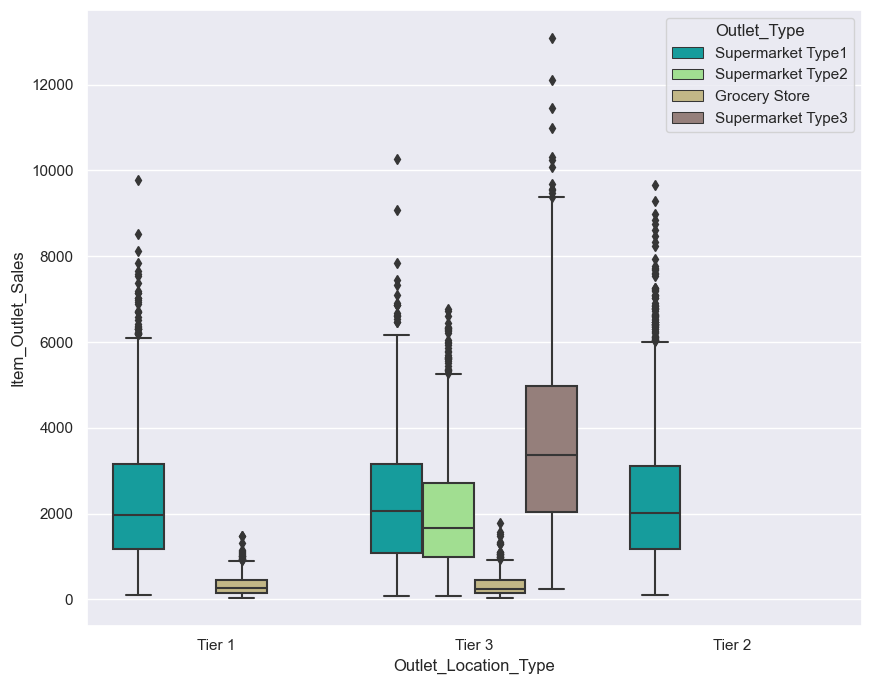

In [33]:
plt.figure(figsize=(10,8))
sns.boxplot(y='Item_Outlet_Sales',hue='Outlet_Type',x='Outlet_Location_Type',data=df_train,palette='terrain')

In [34]:
df_train.drop('Count',axis=1,inplace=True)

C:\Users\local_urmi.pandya\Temp\ipykernel_25808\3586194505.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

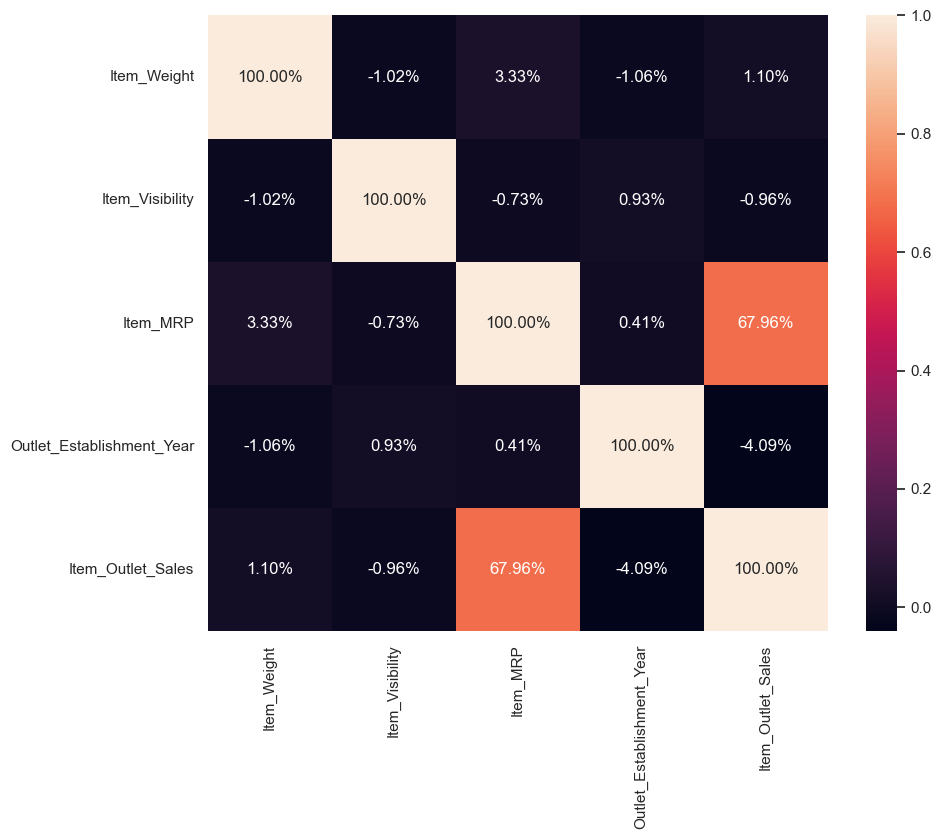

In [35]:
corrs=df_train.dropna().corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs,annot=True,fmt='.2%')

In [36]:
unn_cols=['Item_Weight','Outlet_Size','Item_Identifier','Outlet_Identifier']

for cols in unn_cols:
    df_train.drop(cols,axis=1,inplace=True)

In [37]:
df_train['Item_Fat_Content'].replace('Low Fat',1,inplace=True)
df_train['Item_Fat_Content'].replace('Regular',0,inplace=True)

In [38]:
df_dummies_type=pd.get_dummies(df_train['Item_Type'])

In [39]:
df_train=df_train.merge(df_dummies_type,on=df_train.index)

In [40]:
df_train.drop('key_0',axis=1,inplace=True)
df_train.drop('Item_Type',axis=1,inplace=True)

In [41]:
df_train['Outlet_Location_Type'].replace('Tier 1',1,inplace=True)
df_train['Outlet_Location_Type'].replace('Tier 2',2,inplace=True)
df_train['Outlet_Location_Type'].replace('Tier 3',3,inplace=True)

In [42]:
df_dummies_outlet=pd.get_dummies(df_train['Outlet_Type'])
df_train=df_train.merge(df_dummies_outlet,on=df_train.index)

In [43]:
df_train.drop('key_0',axis=1,inplace=True)
df_train.drop('Outlet_Type',axis=1,inplace=True)

In [44]:
targets=df_train['Item_Outlet_Sales']
df_train.drop('Item_Outlet_Sales',axis=1,inplace=True)
df_train.head()

Item_Fat_Content  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0                 1         0.016047  249.8092                       1999   
1                 0         0.019278   48.2692                       2009   
2                 1         0.016760  141.6180                       1999   
3                 0         0.000000  182.0950                       1998   
4                 1         0.000000   53.8614                       1987   

   Outlet_Location_Type  Baking Goods  Breads  Breakfast  Canned  Dairy  ...  \
0                     1             0       0          0       0      1  ...   
1                     3             0       0          0       0      0  ...   
2                     1             0       0          0       0      0  ...   
3                     3             0       0          0       0      0  ...   
4                     3             0       0          0       0      0  ...   

   Meat  Others  Seafood  Snack Foods  Soft Drinks  Starchy Foods  \
0     0       0        0            0            0              0   
1     0       0        0            0            1              0   
2     1       0        0            0            0              0   
3     0       0        0            0            0              0   
4     0       0        0            0            0              0   

   Grocery Store  Supermarket Type1  Supermarket Type2  Supermarket Type3  
0              0                  1                  0                  0  
1              0                  0                  1                  0  
2              0                  1                  0                  0  
3              1                  0                  0                  0  
4              0                  1                  0                  0  

[5 rows x 25 columns]

In [45]:
X_train,X_test,y_train,y_test=train_test_split(df_train,targets,shuffle=True,test_size=0.2,random_state=0)

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
reg_lin=LinearRegression()
reg_lin.fit(X_train,y_train)

LinearRegression()

In [48]:
reg_lin.score(X_train,y_train)

0.5620345988855906

In [49]:
y_preds_lin=reg_lin.predict(X_test)

In [50]:
rmse_lin=np.sqrt(mean_squared_error(y_preds_lin,y_test))
print('RMSE for Linear Regression:{0:.2f}'.format(rmse_lin))

RMSE for Linear Regression:1130.81


Text(0.5, 1.0, 'Linear Regression \n RMSE: 1130.81')

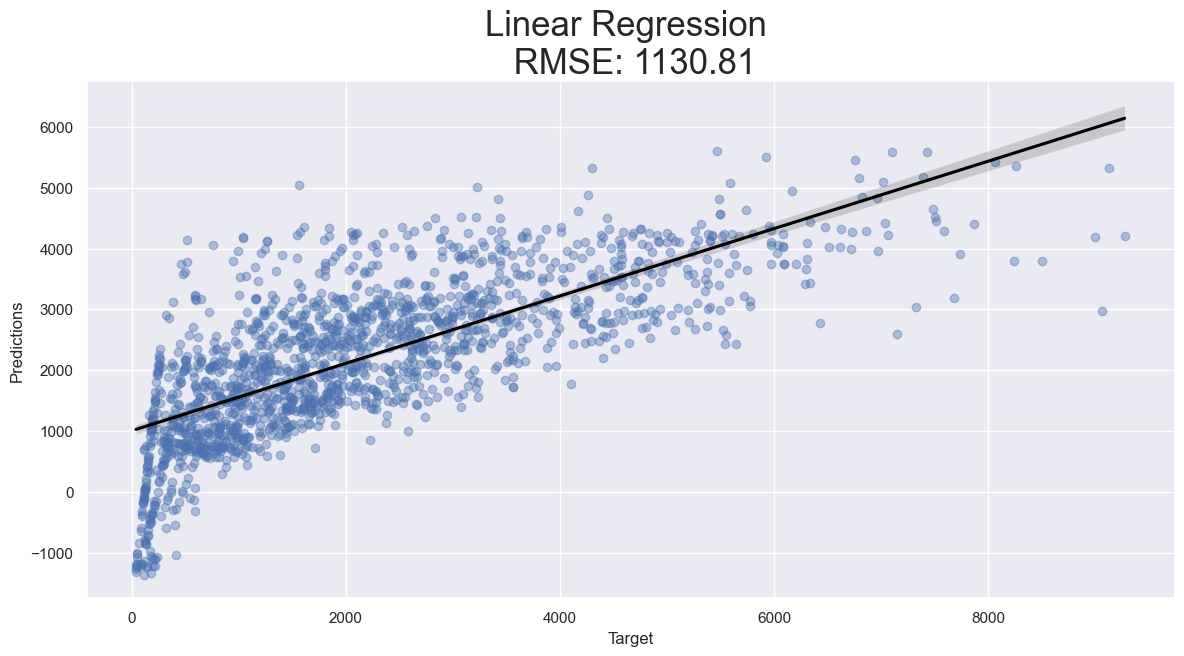

In [51]:
reg_lin_df=pd.DataFrame()
reg_lin_df['Target']=y_test
reg_lin_df['Predictions']=y_preds_lin

sns.lmplot(x='Target',y='Predictions',data=reg_lin_df,height=6,aspect=2,line_kws={'color':'black'},scatter_kws={'alpha':0.4})
plt.title('Linear Regression \n RMSE: {0:.2f}'.format(rmse_lin),size=25)

In [52]:
reg_rid=RidgeCV(cv=10)
reg_rid.fit(X_train,y_train)

RidgeCV(cv=10)

In [53]:
reg_rid.score(X_train,y_train)

0.5619667255114942

In [54]:
y_preds_rid=reg_rid.predict(X_test)
rmse_rid=np.sqrt(mean_squared_error(y_preds_rid,y_test))
print('RMSE for Ridge Regression:{0:.2f}'.format(rmse_rid))

RMSE for Ridge Regression:1130.70


Text(0.5, 1.0, 'Ridge Regression \n RMSE: 1130.70')

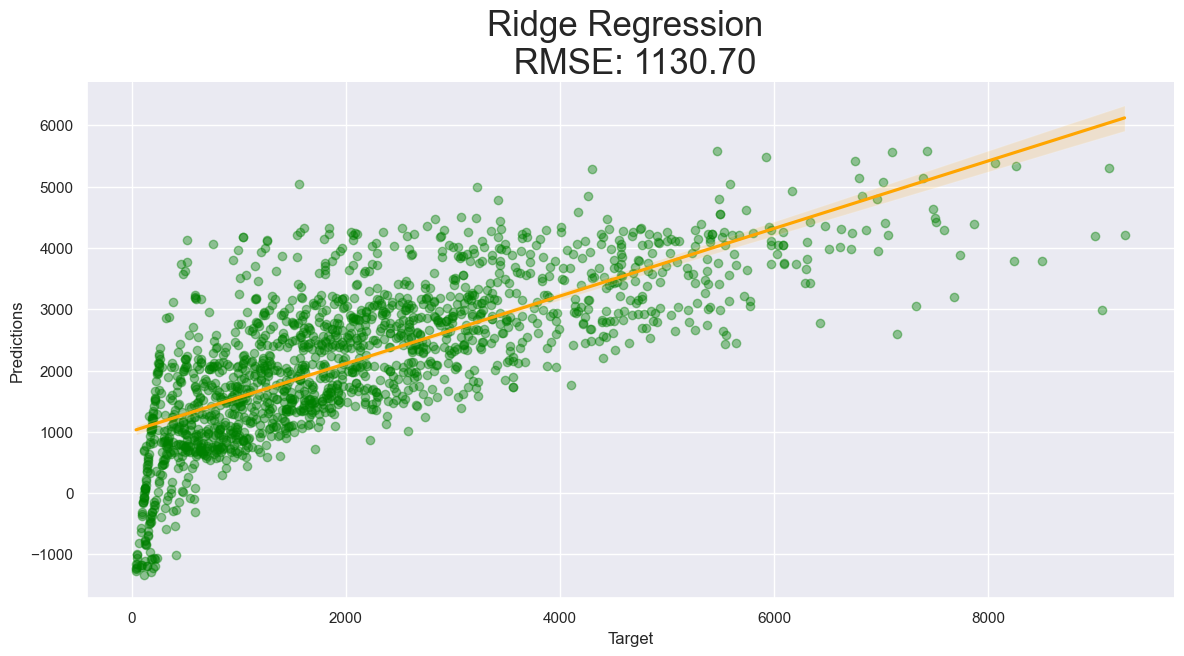

In [55]:
reg_rid_df=pd.DataFrame()
reg_rid_df['Target']=y_test
reg_rid_df['Predictions']=y_preds_rid

sns.lmplot(x='Target',y='Predictions',data=reg_rid_df,height=6,aspect=2,line_kws={'color':'orange'},scatter_kws={'alpha':0.4,'color':'green'})
plt.title('Ridge Regression \n RMSE: {0:.2f}'.format(rmse_rid),size=25)

In [56]:
reg_las=Lasso()
reg_las.fit(X_train,y_train)

Lasso()

In [57]:
reg_las.score(X_train,y_train)

0.5617750843494751

In [58]:
y_preds_las=reg_las.predict(X_test)
rmse_las=np.sqrt(mean_squared_error(y_preds_las,y_test))
print('RMSE for Lasso Regression:{0:.2f}'.format(rmse_las))

RMSE for Lasso Regression:1128.80


Text(0.5, 1.0, 'Lasso Regression \n RMSE: 1128.80')

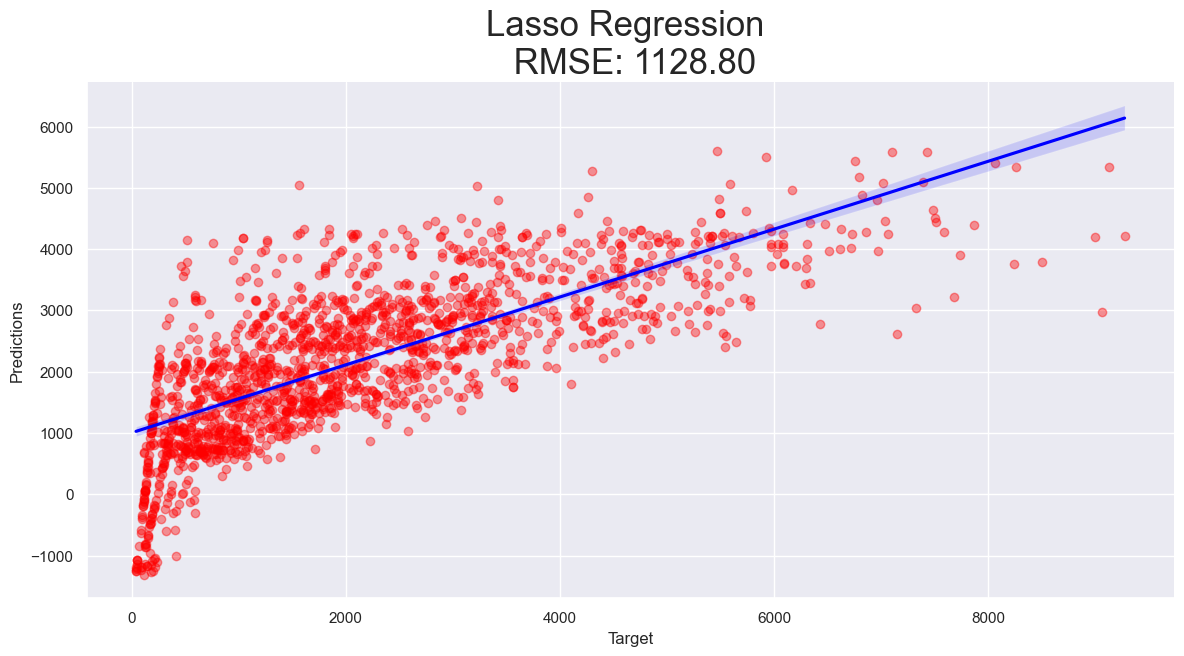

In [59]:
reg_las_df=pd.DataFrame()
reg_las_df['Target']=y_test
reg_las_df['Predictions']=y_preds_las

sns.lmplot(x='Target',y='Predictions',data=reg_las_df,height=6,aspect=2,line_kws={'color':'blue'},scatter_kws={'alpha':0.4,'color':'red'})
plt.title('Lasso Regression \n RMSE: {0:.2f}'.format(rmse_las),size=25)

In [60]:
rfr=RandomForestRegressor(random_state=0)
param_grid={'n_estimators':[3,4,5,7,9,10,12], 'max_depth':[5,7,9,10,12]}
grid=GridSearchCV(rfr,param_grid,scoring='r2',cv=10)

In [61]:
grid_result=grid.fit(X_train,y_train)
grid_result.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [62]:
grid_result.score(X_train,y_train)

0.6037626015518893

In [63]:
y_preds_rfr=grid_result.predict(X_test)
rmse_rfr=np.sqrt(mean_squared_error(y_preds_rfr,y_test))
print('RMSE for Random Forest Regression:{0:.2f}'.format(rmse_rfr))

RMSE for Random Forest Regression:1077.74


Text(0.5, 1.0, 'Random Forest Regression \n RMSE: 1077.74')

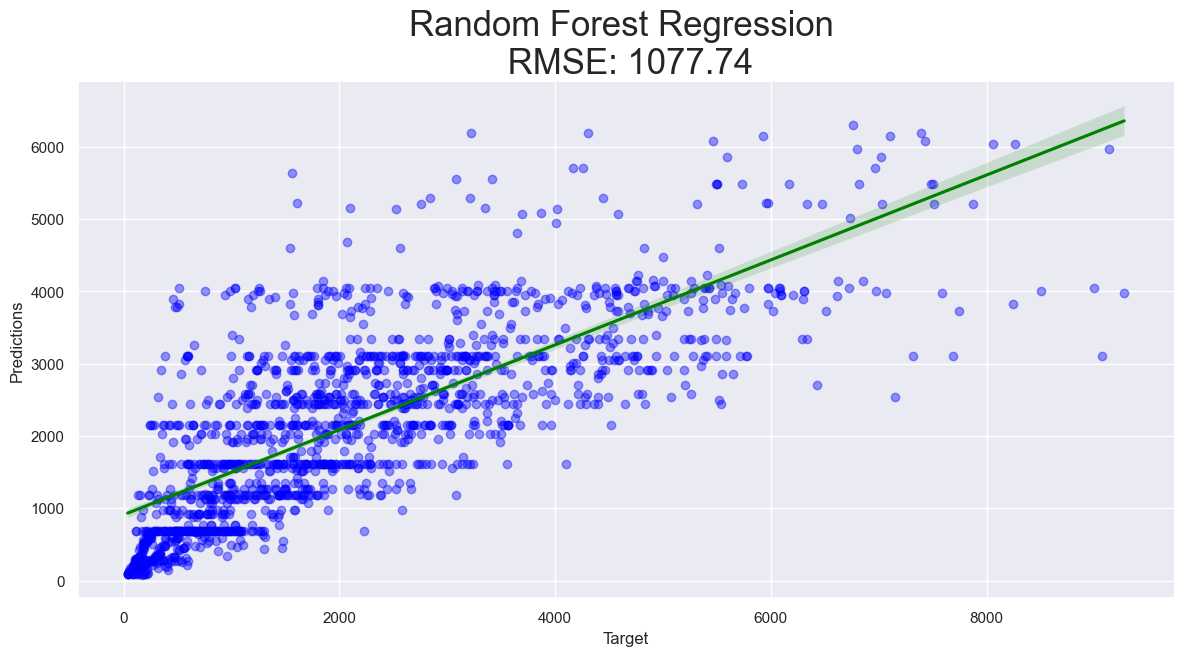

In [64]:
rfr_df=pd.DataFrame()
rfr_df['Target']=y_test
rfr_df['Predictions']=y_preds_rfr

sns.lmplot(x='Target',y='Predictions',data=rfr_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'blue'})
plt.title('Random Forest Regression \n RMSE: {0:.2f}'.format(rmse_rfr),size=25)

In [65]:
gbdt=GradientBoostingRegressor(random_state=0)
gbdt.fit(X_train,y_train)
gbdt.score(X_train,y_train)

0.6313952890813279

In [66]:
y_preds_gbdt=gbdt.predict(X_test)
rmse_gbdt=np.sqrt(mean_squared_error(y_preds_gbdt,y_test))
print('RMSE for Random Forest Regression:{0:.2f}'.format(rmse_gbdt))

RMSE for Random Forest Regression:1080.07


Text(0.5, 1.0, 'GBDT Regression \n RMSE: 1080.07')

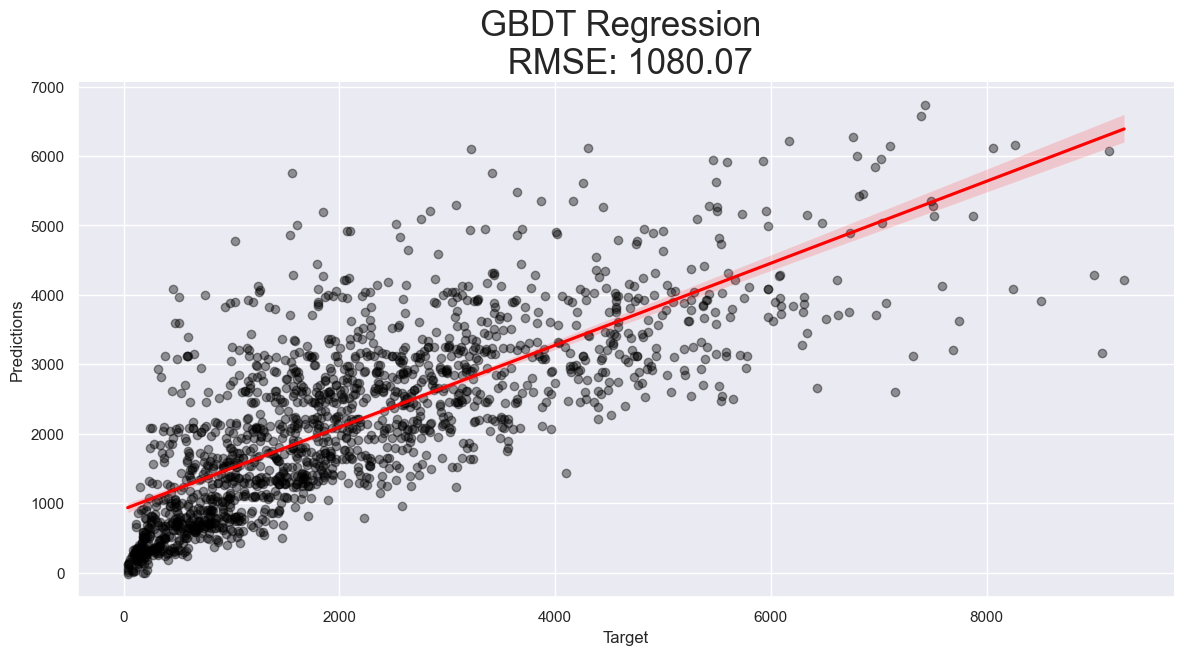

In [67]:
gbdt_df=pd.DataFrame()
gbdt_df['Target']=y_test
gbdt_df['Predictions']=y_preds_gbdt

sns.lmplot(x='Target',y='Predictions',data=gbdt_df,height=6,aspect=2,line_kws={'color':'red'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('GBDT Regression \n RMSE: {0:.2f}'.format(rmse_gbdt),size=25)

In [68]:
ada=AdaBoostRegressor(random_state=0)
ada.fit(X_train,y_train)

AdaBoostRegressor(random_state=0)

In [69]:
y_preds_ada=ada.predict(X_test)
rmse_ada=np.sqrt(mean_squared_error(y_preds_ada,y_test))
print('RMSE for AdaBoost Regression:{0:.2f}'.format(rmse_ada))

RMSE for AdaBoost Regression:1225.99


Text(0.5, 1.0, 'AdaBoost Regression \n RMSE: 1225.99')

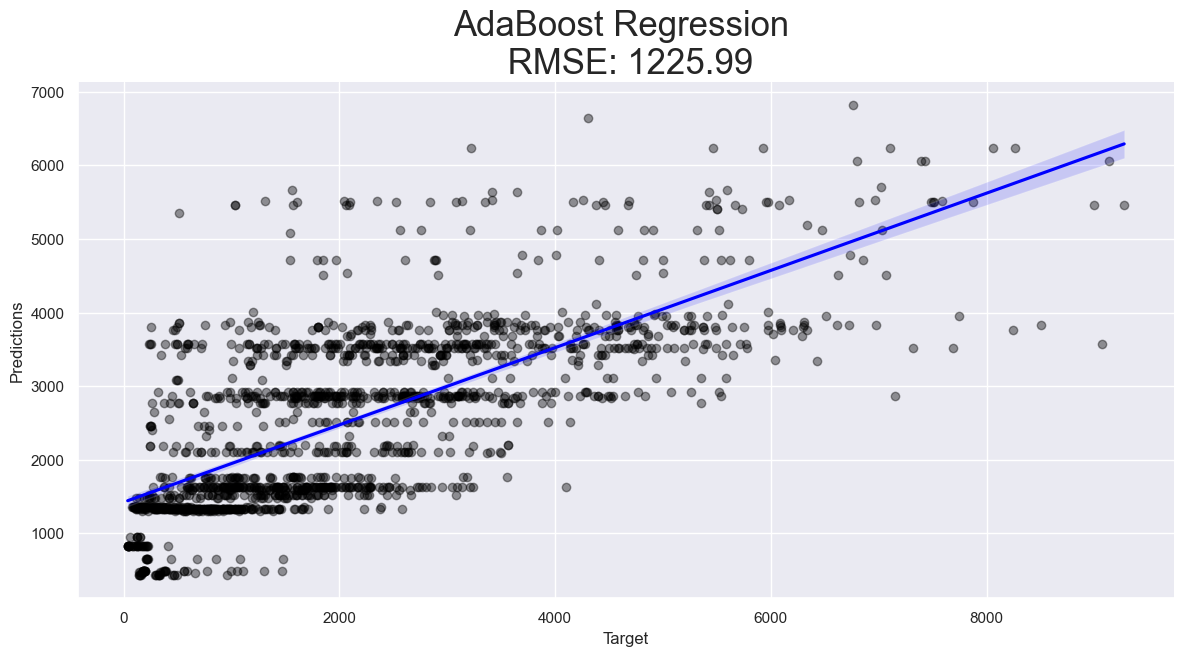

In [70]:
ada_df=pd.DataFrame()
ada_df['Target']=y_test
ada_df['Predictions']=y_preds_ada

sns.lmplot(x='Target',y='Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'blue'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('AdaBoost Regression \n RMSE: {0:.2f}'.format(rmse_ada),size=25)

In [71]:
xgb_reg=xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [72]:
xgb_reg.fit(X_train,y_train)
xgb_reg.score(X_train,y_train)

[17:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



0.7354909548312831

In [73]:
y_preds_xgb=xgb_reg.predict(X_test)
rmse_xgb=np.sqrt(mean_squared_error(y_preds_xgb,y_test))
print('RMSE for XGBoost Regression:{0:.2f}'.format(rmse_xgb))

RMSE for XGBoost Regression:1125.96


Text(0.5, 1.0, 'XGBoost Regression \n RMSE: 1125.96')

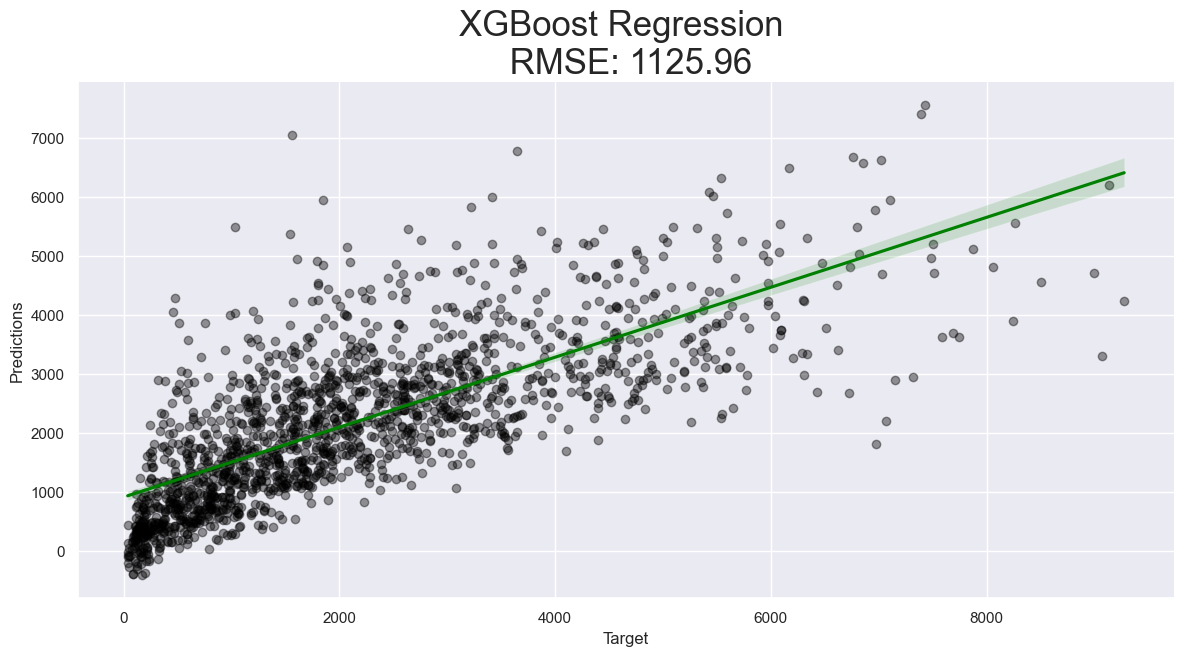

In [74]:
ada_df=pd.DataFrame()
ada_df['Target']=y_test
ada_df['Predictions']=y_preds_xgb

sns.lmplot(x='Target',y='Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'black'})
plt.title('XGBoost Regression \n RMSE: {0:.2f}'.format(rmse_xgb),size=25)

In [75]:
lgb=LGBMRegressor(random_state=0)
lgb.fit(X_train,y_train)
lgb.score(X_train,y_train)

0.7069127746285484

In [76]:
y_preds_lgb=lgb.predict(X_test)
rmse_lgb=np.sqrt(mean_squared_error(y_preds_lgb,y_test))
print('RMSE for LGBM Regression:{0:.2f}'.format(rmse_lgb))

RMSE for LGBM Regression:1097.67


Text(0.5, 1.0, 'LGBM Regression \n RMSE: 1097.67')

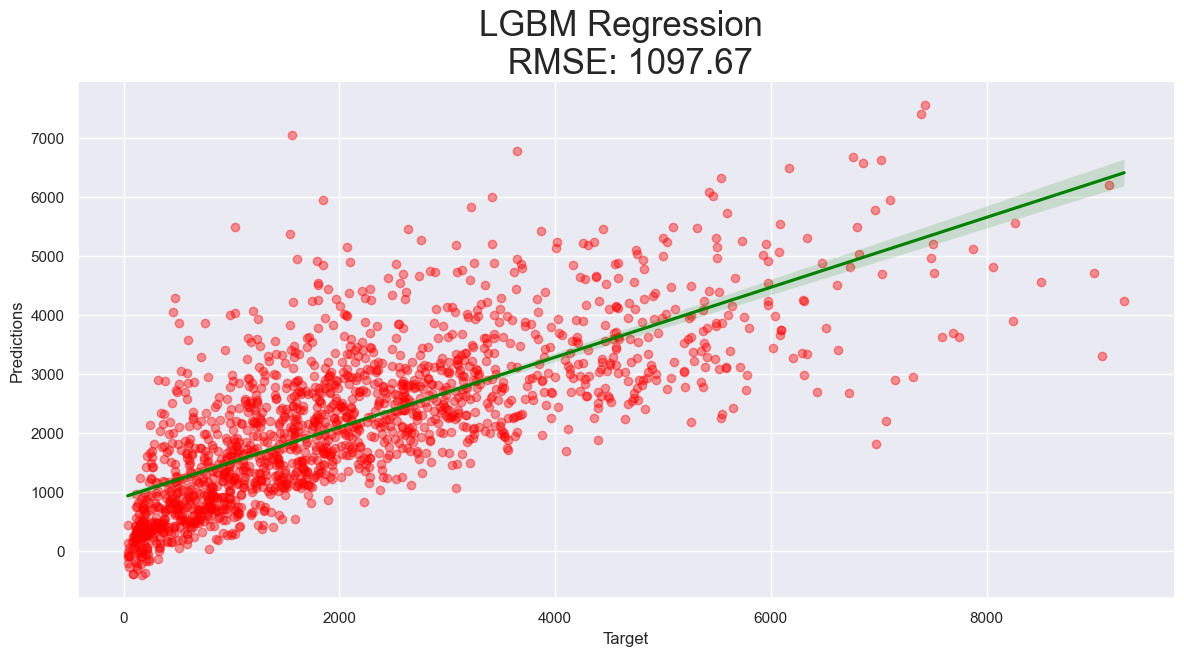

In [77]:
lgb_df=pd.DataFrame()
lgb_df['Target']=y_test
lgb_df['Predictions']=y_preds_lgb

sns.lmplot(x='Target',y='Predictions',data=ada_df,height=6,aspect=2,line_kws={'color':'green'},scatter_kws={'alpha':0.4,'color':'red'})
plt.title('LGBM Regression \n RMSE: {0:.2f}'.format(rmse_lgb),size=25)